## Code

### Libs

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

### Structs

In [30]:
class KMeans:
    def __init__(self, k=2, eps=0.001, max_iter=100):
        self.k = k
        self.eps = eps
        self.max_iter = max_iter
        self.centroids = []

    def fit(self, data):
        for i in range(self.k):
            self.centroids.append(data[np.random.randint(0, data.shape[0])])

        for _ in range(self.max_iter):
            classifications = [[] for i in range(self.k)]

            for feature_set in data:
                distances = [np.linalg.norm(feature_set - self.centroids[k]) for k in range(self.k)]
                classification = np.argmin(distances)
                classifications[classification].append(feature_set)

            prev_centroids = deepcopy(self.centroids)

            for k in range(self.k):
                self.centroids[k] = np.average(classifications[k], axis=0)

            optimized = True

            for k in range(self.k):
                original_centroid = prev_centroids[k]
                current_centroid = self.centroids[k]
                if np.linalg.norm(current_centroid - original_centroid) > self.eps:
                    optimized = False

            if optimized:
                break

        return self.centroids

    def predict(self, data):
        predictions = []
        for feature_set in data:
            distances = [np.linalg.norm(feature_set - self.centroids[i]) for i in range(self.k)]
            predictions.append(np.argmin(distances))
        return np.array(predictions)

### Helping Stuff

In [31]:
data = pd.read_csv('wine.csv')

X = data[data.columns[1:]]
unique_classes = np.unique(data.loc[:, 'class'])
y = data.loc[:, 'class'].map(dict(zip(unique_classes, range(len(unique_classes)))))

X_norm = MinMaxScaler(copy=True).fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_norm)

In [32]:
def contingency_matrix(true_labels, pred_labels):
    cm = [[0 for j in range(len(np.unique(pred_labels)))] for i in range(len(np.unique(true_labels)))]
    for p, l in zip(pred_labels, true_labels):
        cm[l][p] += 1
    return cm

In [34]:
def adjusted_rand_index(true_labels, pred_labels):
    cm = contingency_matrix(true_labels, pred_labels)
    column_sums = np.sum(cm, axis=0)
    row_sums = np.sum(cm, axis=1)
    n = sum(row_sums)

    def c(v):
        return v * (v - 1) / 2

    index = sum([c(v) for row in cm for v in row])
    expected_index = sum([c(a) for a in row_sums]) * sum([c(b) for b in column_sums]) / c(n)
    max_index = 1 / 2 * (sum([c(a) for a in row_sums]) + sum([c(b) for b in column_sums]))

    return (index - expected_index) / (max_index - expected_index)

In [35]:
def silhouette(X, pred_labels, centroids):
    clusters, counts = np.unique(pred_labels, return_counts=True)
    n_clusters = len(clusters)

    clusters_X = [np.array([]) for i in range(n_clusters)]
    for cluster in clusters:
        clusters_X[cluster] = X[pred_labels == cluster, :]

    silhouettes = []
    for cluster in clusters:
        internal_distance = np.mean([np.linalg.norm(x - centroids[cluster]) for x in clusters_X[cluster]])

        external_distances = []
        for other_cluster in clusters:
            if other_cluster != cluster:
                distances = [np.linalg.norm(x - centroids[other_cluster]) for x in clusters_X[cluster]]
                external_distances.append(np.mean(distances) if len(distances) else 0.0)

        external_distance = min(external_distances) if len(external_distances) else 0.0
        silhouettes.append((external_distance - internal_distance) / max([internal_distance, external_distance]))

    return sum(silhouettes) / n_clusters

In [36]:
def display_clusters(labels, title):
    plt.figure(figsize=(6, 6))
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        cur_xs = X_pca[labels == label, 0]
        cur_ys = X_pca[labels == label, 1]
        plt.scatter(cur_xs, cur_ys, alpha=0.5, label=label)
    plt.title(title)
    plt.xlabel("X координата")
    plt.ylabel("Y координата")
    plt.legend()
    plt.show()

In [37]:
def display_metrics(n_clusters, metrics, title):
    plt.figure(figsize=(8, 6))
    plt.grid(linestyle='--')
    plt.plot(n_clusters, metrics, linestyle='-', marker='.', color='r')
    plt.title(title)
    plt.xlabel("Количество кластеров")
    plt.ylabel("Значение метрики")
    plt.show()

## Resutls

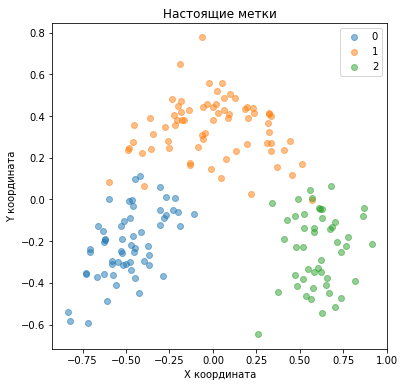

In [38]:
display_clusters(y, "Настоящие метки")

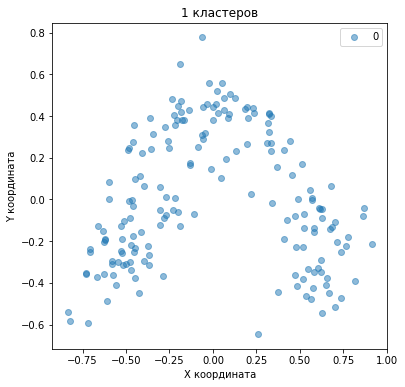

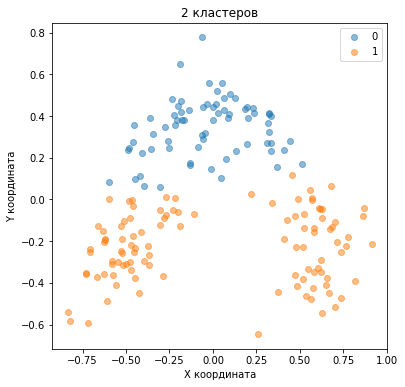

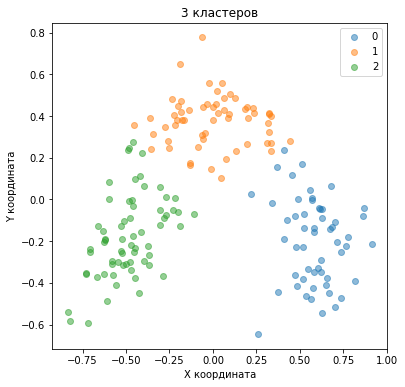

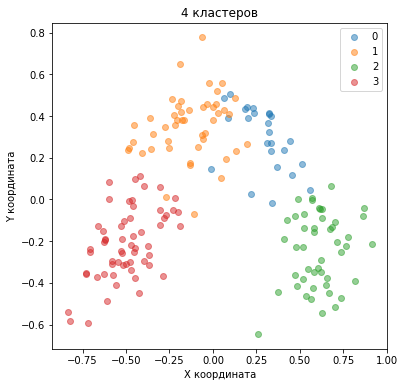

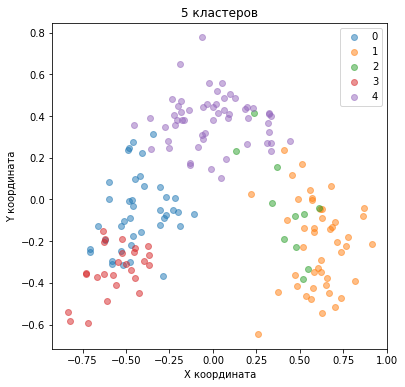

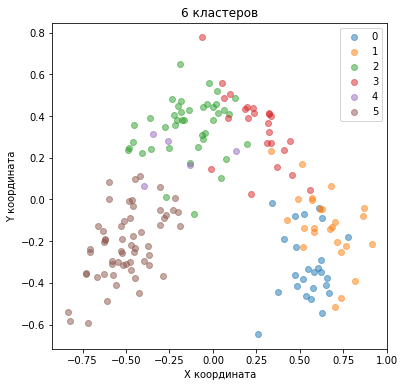

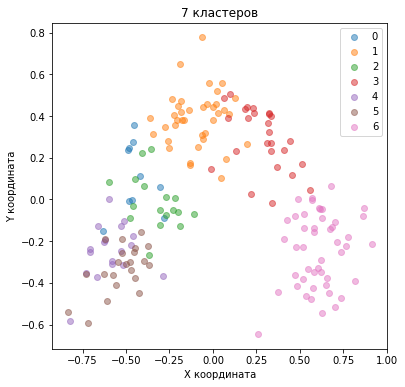

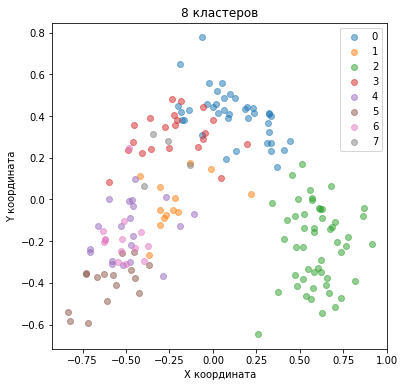

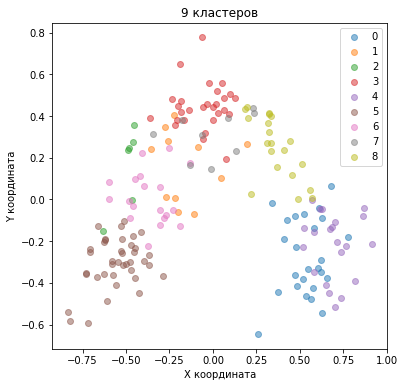

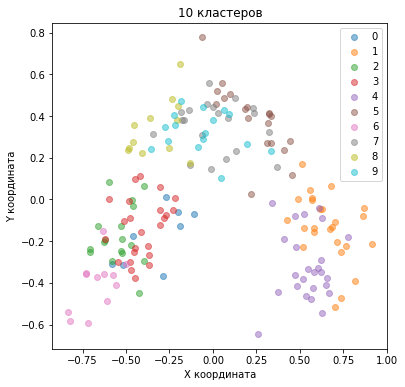

In [39]:
external_metrics = []
internal_metrics = []
for i in range(1, 11):
    kMean = KMeans(k=i)
    centroids = kMean.fit(X_norm)
    y_pred = kMean.predict(X_norm)
    if i == 1:
        internal_metrics.append(0.0)
    else:
        internal_metrics.append(silhouette(X_norm, y_pred, centroids))

    external_metrics.append(adjusted_rand_index(y, y_pred))
    display_clusters(y_pred, str(i) + ' кластеров')

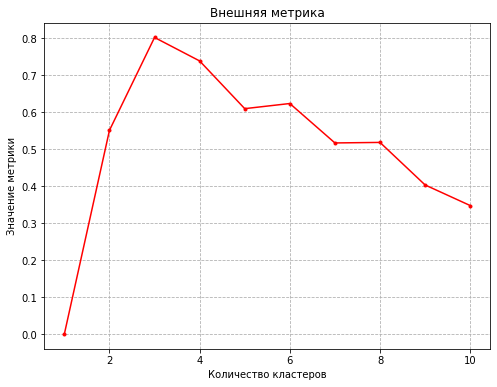

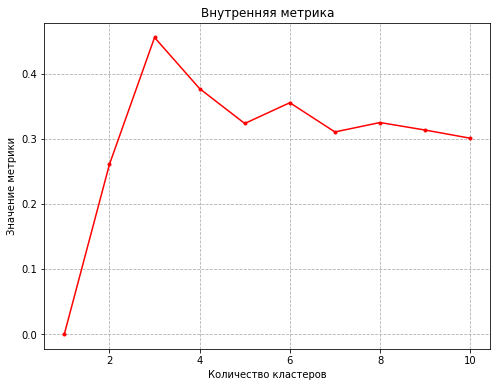

In [40]:
display_metrics(range(1, 11), external_metrics, 'Внешняя метрика')
display_metrics(range(1, 11), internal_metrics, 'Внутренняя метрика')